In [18]:
import dask

In [165]:
import dask
import dask.distributed
dask.config.config["distributed"]["worker"]["memory"]
from dask import delayed
import dask
dask.config.config["distributed"]["worker"]

{'blocked-handlers': [],
 'multiprocessing-method': 'spawn',
 'use-file-locking': True,
 'connections': {'outgoing': 50, 'incoming': 10},
 'preload': [],
 'preload-argv': [],
 'daemon': True,
 'validate': False,
 'lifetime': {'duration': None, 'stagger': '0 seconds', 'restart': False},
 'profile': {'interval': '10ms', 'cycle': '1000ms', 'low-level': False},
 'memory': {'target': 0.6, 'spill': 0.7, 'pause': 0.8, 'terminate': 0.95},
 'http': {'routes': ['distributed.http.worker.prometheus',
   'distributed.http.health',
   'distributed.http.statics']}}

In [20]:
from dask_gateway import GatewayCluster
from dask.distributed import Client, LocalCluster
cluster = GatewayCluster(
    worker_cores=2,
    worker_memory=8,
    image="eu.gcr.io/gke-dev-311213/dask-gateway-physlite:20210622"
)
cluster

In [153]:
cluster.scale(500)

In [25]:
dask_client = cluster.get_client()

In [172]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'gcp_auth.json'
from google.cloud.bigquery_storage import BigQueryReadClient
from google.cloud.bigquery_storage import types,SplitReadStreamRequest

gcp_project = 'gke-dev-311213'
gcp_dataset = 'PHYSLITE100TB'
table_name = 'physlitetestdata'

v = 'personalstuff-309012'
table = f"projects/{gcp_project}/datasets/{gcp_dataset}/tables/{table_name}"

requested_session = types.ReadSession()
requested_session.table = table
requested_session.data_format = types.DataFormat.ARROW

client = BigQueryReadClient()
parent = f"projects/{gcp_project}"
session = client.create_read_session(
    parent=parent,
    read_session=requested_session,
    max_stream_count=1000,
)
session.read_options.selected_fields = ['Jets']

streams = session.streams
len(streams)

1000

In [120]:
def split_stream(source):
    req = SplitReadStreamRequest(name = source.name,fraction = 0.5)
    res = client.split_read_stream(req)
    a,b = res.primary_stream,res.remainder_stream
    return a,b

def double_streams(streams):
    out = [y for x in streams for y in split_stream(x)]
    return out

# streams = double_streams(streams)
# len(streams)

In [29]:
def get_pages(stream):
    reader = client.read_rows(streams[0].name)
    from google.cloud.bigquery_storage_v1.reader import ReadRowsIterable
    rit = ReadRowsIterable(reader,session)
    pages = list(rit.pages)
    return pages

In [30]:
auth = open(os.environ['GOOGLE_APPLICATION_CREDENTIALS']).read()
import json
ReadSession = types.ReadSession

In [121]:
import awkward as ak
import numpy as np
import tempfile
from google.cloud.bigquery_storage_v1.reader import ReadRowsIterable
def process_page(page):
    data = ak.from_arrow(page)
#     return np.asarray(ak.flatten(data.Jets.pt[:,:1]/100000))
    return np.histogram(np.asarray(ak.flatten(data.Jets.pt[:,:1]/10000)), bins = np.linspace(0,100,101))[0]

def read(auth,session_payload,stream_name):
    session = ReadSession.deserialize(session_payload)
    t = tempfile.NamedTemporaryFile(mode = 'w', delete = False)
    t.write(auth)
    t.close()
    json.load(open(t.name))
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = t.name
    client = BigQueryReadClient()    
    reader = client.read_rows(stream_name)
#     page_data = [process_page(reader.to_arrow(session))]   
    rit = ReadRowsIterable(reader,session)
    page_data = ak.sum([process_page(page.to_arrow()) for page in rit.pages],axis=0)
    return page_data
#     return ak.sum(page_data) if page_data else ak.Array([])[0]


In [122]:
a = read(auth,ReadSession.serialize(session),streams[0].name)

[]

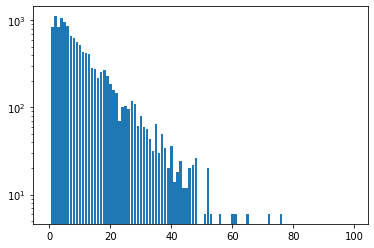

In [123]:
import matplotlib.pyplot as plt
plt.bar(range(len(a)),a)
plt.semilogy()

In [124]:
read(auth,ReadSession.serialize(session),streams[0].name)

<Array [0, 839, 1115, 834, ... 0, 0, 0, 0] type='100 * int64'>

In [161]:
futs = [delayed(read)(
        auth,
        ReadSession.serialize(session),
        s.name
    ) for s in streams[:] + streams[:] + streams[:] + streams[:] + streams[:] + streams[:] + streams[:] + streams[:]
#         + streams[:] + streams[:]
]
print(len(futs))

8000


In [162]:
import time
start = time.time()
filtered = delayed(ak.sum)(futs,axis=0).compute()
time.time()-start

119.63878512382507

In [144]:
filtered

<Array [0, 1359541, 1798778, ... 0, 0, 0] type='100 * int64'>

[]

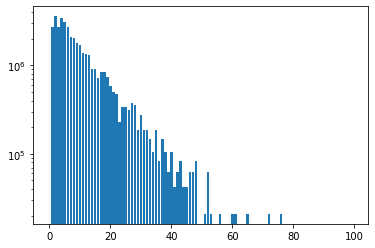

In [149]:
import matplotlib.pyplot as plt
plt.bar(np.arange(len(filtered)),filtered);
plt.semilogy()

In [164]:
cluster.scale(0)

In [163]:
np.sum(filtered)

163981520